# Titanic: Machine Learning from Disaster

In [1]:
# https://www.kaggle.com/c/titanic

In [20]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Загружаем данные из файлов
train = pd.read_csv('./titanic/train.csv')
test = pd.read_csv('./titanic/test.csv')

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Предобработка данных

In [6]:
# Заполняем пропуски в данных медианными 
# значениями факторов на обучающей выборке
train_median = train.median()
train_imp = train.fillna(train_median)
test_imp = test.fillna(train_median)

In [7]:
# Бинаризуем категориальные признаки
CATEGORY_COL = ['Sex', 'Pclass', 'Embarked']
train_dummies = pd.get_dummies(train_imp, columns=CATEGORY_COL, drop_first=True)
test_dummies = pd.get_dummies(test_imp, columns=CATEGORY_COL, drop_first=True)

In [8]:
train_dummies.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_male,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,1,0,1,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,1,0,1,0,1


In [10]:
# Удаляем лишние столбцы
DROP_COL = ['PassengerId', 'Name', 'Ticket', 'Cabin']
TARGET_COL = 'Survived'
X_train = train_dummies.drop(DROP_COL + [TARGET_COL], axis=1)
y_train = train_dummies[TARGET_COL]
X_test = test_dummies.drop(DROP_COL, axis=1)

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, scorer, accuracy_score

## Предсказание моделей для стеккинга

In [71]:
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

def cross_val_predict_proba(estimator, X_train, y_train):
    kfold = KFold(n_splits=4, shuffle=True, random_state=None)
    return cross_val_predict(estimator, X_train, y_train, cv=kfold, method='predict_proba')

# TODO: подобрать гиперпараметры для ансамблей

pipeline_ens_gbc = Pipeline(steps=[#('rfc_est', RandomForestClassifier()),
                           ('gbc_est', GradientBoostingClassifier(learning_rate=0.1, \
                                                                  min_samples_split=500,\
                                                                  min_samples_leaf=50,\
                                                                  max_depth=8,\
                                                                  max_features='sqrt',\
                                                                  subsample=0.8,\
                                                                  random_state=10))
                          ])

pipeline_ens_lgr = Pipeline(steps=[#('rfc_est', RandomForestClassifier()),
                           ('lgr_est', LogisticRegression(C=1))
                          ])




pipeline_ens_rfc = Pipeline(steps=[('rfc_est', RandomForestClassifier())
                           #('gbc_est', GradientBoostingClassifier())
                          ])


param_grid_ens_gbc = {#'rdc_est__max_depth': range(1,100),
                  'gbc_est__n_estimators': range(30, 120, 10)
}

param_grid_ens_rfc = {'rfc_est__max_depth': range(1,100)
                  #'gbc_est__n_estimatores': range(30, 80, 10)
                     }


param_grid_ens_lgr = {'lgr_est__C': [1,10,100,1000,10000]
                  #'gbc_est__n_estimatores': range(30, 80, 10)
                     }

grid_ens_gbc = GridSearchCV(pipeline_ens_gbc, param_grid_ens_gbc, 
                    scoring=make_scorer(accuracy_score),
                    cv=kfold)


grid_ens_rfc = GridSearchCV(pipeline_ens_rfc, param_grid_ens_rfc, 
                    scoring=make_scorer(accuracy_score),
                    cv=kfold)

grid_ens_lgr = GridSearchCV(pipeline_ens_lgr, param_grid_ens_lgr, 
                    scoring=make_scorer(accuracy_score),
                    cv=kfold)

# инициализирем модели с подобранными гиперпараметрами
lgr_estimator = grid_ens_lgr.fit(X_train, y_train)
rf_estimator = grid_ens_rfc.fit(X_train, y_train)
gb_estimator = grid_ens_gbc.fit(X_train, y_train)



In [72]:
grid_ens_rfc.grid_scores_, grid_ens_rfc.best_params_, grid_ens_rfc.best_score_

/Users/Feldman/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.74411, std: 0.06796, params: {'rfc_est__max_depth': 1},
  mean: 0.76655, std: 0.04574, params: {'rfc_est__max_depth': 2},
  mean: 0.80247, std: 0.04700, params: {'rfc_est__max_depth': 3},
  mean: 0.82267, std: 0.03551, params: {'rfc_est__max_depth': 4},
  mean: 0.82604, std: 0.03766, params: {'rfc_est__max_depth': 5},
  mean: 0.82604, std: 0.03843, params: {'rfc_est__max_depth': 6},
  mean: 0.82828, std: 0.02941, params: {'rfc_est__max_depth': 7},
  mean: 0.81930, std: 0.02625, params: {'rfc_est__max_depth': 8},
  mean: 0.82155, std: 0.02780, params: {'rfc_est__max_depth': 9},
  mean: 0.82828, std: 0.02749, params: {'rfc_est__max_depth': 10},
  mean: 0.81706, std: 0.03818, params: {'rfc_est__max_depth': 11},
  mean: 0.80808, std: 0.04518, params: {'rfc_est__max_depth': 12},
  mean: 0.81481, std: 0.04120, params: {'rfc_est__max_depth': 13},
  mean: 0.81930, std: 0.02951, params: {'rfc_est__max_depth': 14},
  mean: 0.80920, std: 0.03401, params: {'rfc_est__max_depth': 15},
  me

In [73]:
grid_ens_gbc.grid_scores_, grid_ens_gbc.best_params_, grid_ens_gbc.best_score_

/Users/Feldman/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.78676, std: 0.04488, params: {'gbc_est__n_estimators': 30},
  mean: 0.78900, std: 0.04482, params: {'gbc_est__n_estimators': 40},
  mean: 0.79012, std: 0.03882, params: {'gbc_est__n_estimators': 50},
  mean: 0.78900, std: 0.03569, params: {'gbc_est__n_estimators': 60},
  mean: 0.79237, std: 0.03983, params: {'gbc_est__n_estimators': 70},
  mean: 0.79798, std: 0.03645, params: {'gbc_est__n_estimators': 80},
  mean: 0.80022, std: 0.03774, params: {'gbc_est__n_estimators': 90},
  mean: 0.80359, std: 0.03816, params: {'gbc_est__n_estimators': 100},
  mean: 0.80584, std: 0.03775, params: {'gbc_est__n_estimators': 110}],
 {'gbc_est__n_estimators': 110},
 0.8058361391694725)

In [74]:
grid_ens_lgr.grid_scores_, grid_ens_lgr.best_params_, grid_ens_lgr.best_score_

/Users/Feldman/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.80359, std: 0.03636, params: {'lgr_est__C': 1},
  mean: 0.80022, std: 0.04081, params: {'lgr_est__C': 10},
  mean: 0.79910, std: 0.04065, params: {'lgr_est__C': 100},
  mean: 0.79798, std: 0.04205, params: {'lgr_est__C': 1000},
  mean: 0.79798, std: 0.04205, params: {'lgr_est__C': 10000}],
 {'lgr_est__C': 1},
 0.80359147025813693)

In [84]:
# получаем предсказания вероятностей ансамблей на кросс-валидации для обучающей выборки
rf_train_pred = cross_val_predict_proba(rf_estimator, X_train, y_train)
gb_train_pred = cross_val_predict_proba(gb_estimator, X_train, y_train)
lgr_train_pred = cross_val_predict_proba(lgr_estimator, X_train, y_train)



# получаем предсказания ансамблей для тестовой выборки
rf_test_pred = rf_estimator.fit(X_train, y_train).predict_proba(X_test)
gb_test_pred = gb_estimator.fit(X_train, y_train).predict_proba(X_test)
lgr_test_pred = lgr_estimator.fit(X_train, y_train).predict_proba(X_test)



In [90]:
train_array = [rf_train_pred[:,1], gb_train_pred[:,1], lgr_train_pred[:,1]]
test_array = [rf_test_pred[:,1], gb_test_pred[:,1], lgr_test_pred[:,1]]
#X_train_stack = np.stack([rf_train_pred[:,1], gb_train_pred[:,1]], lgr_train_pred[:,1], axis=1)
X_train_stack = np.stack(train_array, axis=1)
X_test_stack = np.stack(test_array, axis=1)

## Объединяем предсказания ансамблей с помощью логистической регрессии

In [91]:
# TODO: подобрать гиперпараметры LogisticRegression




kfold = KFold(n_splits=10, shuffle=True, random_state=1243)

pipeline = Pipeline(steps=[
                           ('model', LogisticRegression(C=1, penalty='l2'))
                          ])

param_grid = {'model__C': [1,10,100,1000,10000]}

grid = GridSearchCV(pipeline, param_grid, 
                    scoring=make_scorer(accuracy_score),
                    cv=kfold)

In [92]:




logreg = grid.fit(X_train_stack, y_train)
predicted = logreg.predict(X_test_stack)
logreg.cv_results_['mean_test_score']

array([ 0.81818182,  0.81705948,  0.81705948,  0.81705948,  0.81705948])

In [93]:
logreg.grid_scores_, logreg.best_params_, logreg.best_score_

/Users/Feldman/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.81818, std: 0.03639, params: {'model__C': 1},
  mean: 0.81706, std: 0.03758, params: {'model__C': 10},
  mean: 0.81706, std: 0.03758, params: {'model__C': 100},
  mean: 0.81706, std: 0.03758, params: {'model__C': 1000},
  mean: 0.81706, std: 0.03758, params: {'model__C': 10000}],
 {'model__C': 1},
 0.81818181818181823)

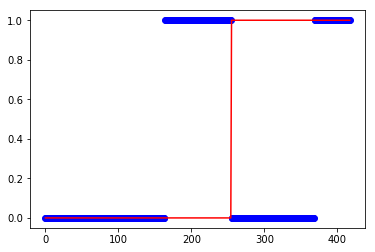

In [94]:
pairs = np.array(sorted(zip(y_train, predicted)))
plt.plot(range(0, len(pairs)), pairs[:,1], 'bo',
         range(0, len(pairs)), pairs[:,0], 'r-',)
plt.show()

## Формируем фалй для отправки

In [95]:
with open('submission.txt', 'w') as out:
    out.write('PassengerId,Survived\n')
    for passenger, y in zip(test['PassengerId'], predicted):
        out.write('%s,%s\n' % (passenger, y))